### Objective
Are countries with proximity to higher levels Co2 more impacted than the rest of the countiers in terms of temperature change?

### Summary
Using the temperature dataset smoothed by EWMA (Approach 1), we performed hypothesis tests to compare mean temperature changes for two groups of the countries - ones with proximity to higher levels Co2 and the rest. We defined "temperature change" in two ways - 1) dividing changes from 1960 to 2010 with the number of years (Approach 2), and 2) slope of a linear line fitted to temperature trend data (Approach 3) - and found that there is no differences in temperature change between the two groups regardless of the definition.

### Approach 1. Exponentially Weighted Moving Average as baseline
As we explored in [the previous analysis](https://github.com/masamurai/AppliedDataScience/blob/master/project/notebooks/100-temperature-change.ipynb), temperature data flactuate over the time due to noise in the data even after annualized, which is not ideal for modeling. Therefore, our first step is to smooth the raw temperature data using EWMA method.

#### Load packages

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#### Load datasets

In [5]:
# load dataset
df = pd.read_csv('../data/ADS_project_dataset2.csv', header=0, parse_dates=[0], squeeze=True)

# exclude rows with missing average temperature
df_temp = df[(df.Year >= 1960) & (df.Year <= 2012)].loc[:,['Country', 'Year', 'AveTemperature']]

#### Define functions

In [6]:
def get_rsme(df, span, chart=False, chart_list=None):
    '''
    get RMSE for each span, and plot chart for countries in chart_list if chart is True
    
    '''  
    countr_list = list(df['Country'].unique())
    rsme_list = []
    df_master = pd.DataFrame()
    
    for i in country_list: 
        year = df[df['Country'] == i].sort_values('Year').Year
        series = df[df['Country'] == i].sort_values('Year').AveTemperature
        ewma = pd.ewma(series, span=span)
        df_comb = pd.DataFrame({'ewma': ewma, 'observed': series})
        
        if chart and (i in chart_list):
            df_comb.plot(title = i + ': observed vs. smoothed temperatures')
        
        df_comb['squared_error'] = (df_comb.ewma - df_comb.observed) ** 2
        df_comb['Country'] = i
        df_comb['Year'] =year
        rsme = np.sqrt(df_comb.squared_error.sum() / df_comb.shape[0])
        rsme_list.append(rsme)
        df_master = df_master.append(df_comb, ignore_index=True)
    
    rsme = np.sum(rsme_list) / len(rsme_list)
    return rsme, df_master

In [7]:
def find_best_span(df, span_list):
    '''
    cycle through a list containing spans and return corresponding RSME
    '''
    rmse_master_list = []
    for j in span_list:
        rsme, _ = get_rsme(df, j)
        rmse_master_list.append(rsme)
#         print('span=' + str(j) + ', rsme=' + str(rsme))
    return rmse_master_list

#### Hyperparameter Search
Exponentially weighted moving average (EWMA) requires a hyperparameter alpha, which is often defined with a span. 10 years would be a typical span for smoothing temperature data, but we are validating this knowledge with a hyperparameter search on our temperature data in this section. Note that I am not looking for a hyperparameter that minimizes validation RMSE given EWMA is a smoothing method and there is no train-validation setup typically found in machine learning modeling. Rather, I am looking for a span with which gain in RMSE diminishes, and comparing the span against knowledge from domain experts.

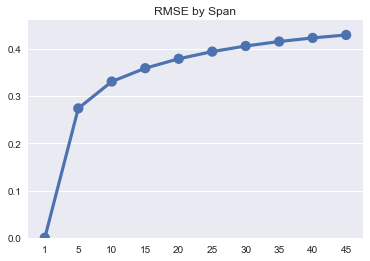

In [12]:
# get a list of countries in the dataset
country_list = df_temp['Country'].unique()

# create a list of spans to get RMSE
span_list = [1] + list(range(5, 50, 5))

# get RMSE for spans
rmse = find_best_span(df_temp, span_list)

# plot spans and corresponding RMSE
plt.title('RMSE by Span')
g = sns.pointplot(x=span_list, y=rmse)
g.set(ylim=(0, None));

The chart above indicates that gains in RMSE becomes stable around the span of 10. This validates domain knowledge and the span of 10 is used for our hyperparameter for the rest of the analysis.

#### Modeling
In this section, I run EWMA for every country in the dataset using a span of 10 years, and create a dataset containing smoothed average temperatures, which will be used for hypothesis testings.

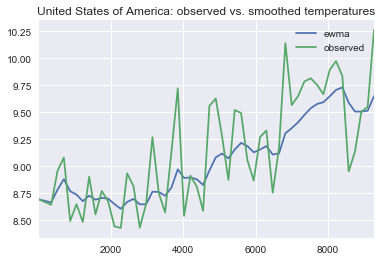

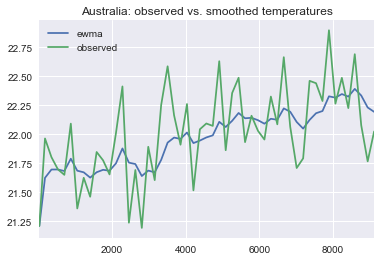

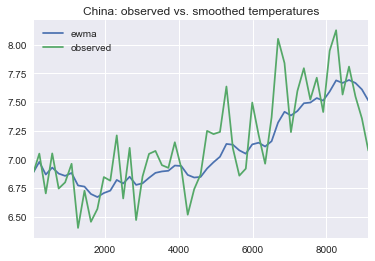

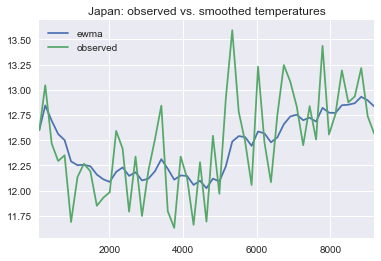

In [78]:
# create a list of countries to spot-check by plotting their observed and smoothed average temperatures
chart_list = ['China', 'Australia', 'Japan', 'United States of America']

# create a dataset containing smoothed average temparatures using EWMA with a span of 10
rsme, df_master = get_rsme(df_temp, 10, chart=True, chart_list = chart_list)

In [196]:
rsme

0.3306388795940953

In [206]:
df_master.head()

,ewma,observed,squared_error,Country,Year
0,25.167250,25.167250,0.000000,Bahamas,1960
1,25.286325,25.383750,0.009492,Bahamas,1961
2,25.207236,25.089583,0.013842,Bahamas,1962
3,25.188819,25.151333,0.001405,Bahamas,1963
4,25.264993,25.454167,0.035787,Bahamas,1964


In [207]:
# save the dataset 
df_master.to_csv('../data/ewma.csv', index=False)

### Approach 2. Hypothesis Test

Now we have smoothed temperature data, our next step is to perform a hyothesis test to answer the question on consistency of temperature change across the countries depending on their proximity to higher level Co2. Our null and alternative hypothesis as follows.

* H0 (Null) CO2 impacts everyone irrespective of Co2 proximity
* Ha (alternate) Those countries with proximity to higher levels Co2 (i.e. <2000) are more impacted


* dataset1 = average temperatures change 1960-2010 fro countries with <=80% Co2 within 2000 miles
* dataset2 = average temperatures change 1960-2010 for countries with >80% Co2 within 2000 miles


* H0 = Mean (dataset 2) - Mean (dataset 1) = 0
* Ha = Mean (dataset 2) - Mean (dataset 1) > 0

** NOTE: **
* average temperatures change is defined as the difference between first (1960) and last year (2012) in the dataset, divided by number of years.

#### Load packages

In [14]:
from scipy.stats import ttest_ind

#### Load and clean data

In [15]:
# load dataset containing smoothed average temperatures
df = pd.read_csv('../data/ewma.csv', header=0, parse_dates=[0], squeeze=True)

In [16]:
# compute average temperature change
df_change = df[df.Year.isin(['1960', '2012'])] \
            .loc[:,['Country','Year', 'ewma']] \
            .pivot(index='Country', columns='Year', values='ewma')

df_change[1960] = pd.to_numeric(df_change[1960])
df_change[2012] = pd.to_numeric(df_change[2012])

# average temperatures change is defined as the difference between first (1960) and last year (2012) in the dataset, 
# divided by number of years.
df_change['AvgTempChange'] = (df_change[2012] - df_change[1960] ) / (2012 - 1960 + 1)
df_change.reset_index().to_csv('../data/df_avg_temp_change.csv', index=False)

# get a list of countries >80% Co2 within 2000 miles
df_co2 = pd.read_csv('../data/ADS_project_dataset2.csv', header=0, parse_dates=[0], squeeze=True)
df_total_co2prox2000 = df_co2.groupby('Country').CO2prox2000.sum().to_frame()
cutoff80pct = np.percentile(df_total_co2prox2000, 80)
df_change['flag80pctCO2'] = df_total_co2prox2000.CO2prox2000 >= cutoff80pct

series_80pctCO2 = pd.Series(df_change[df_change['flag80pctCO2']].index)
series_80pctCO2.to_csv('../data/list_80pctCO2.csv', index=False)

# get average temperature changes for countries >80% Co2 within 2000 miles
TempChange80plus = df_change[df_change['flag80pctCO2']].AvgTempChange

# get average temperature changes for countries <=80% Co2 within 2000 miles
TempChange80less = df_change[~df_change['flag80pctCO2']].AvgTempChange

In [18]:
# list countries >80% Co2 within 2000 miles for validation
df_change[df_change['flag80pctCO2']]

Year,1960,2012,AvgTempChange,flag80pctCO2
Country,,,,
Algeria,23.504083,24.211963,0.013356,True
Bahamas,25.167250,25.790242,0.011755,True
Bangladesh,25.484250,25.519196,0.000659,True
Belize,25.351583,25.731637,0.007171,True
Cambodia,27.172417,27.372887,0.003782,True
Canada,-4.406833,-3.474706,0.017587,True
China,6.890917,7.513387,0.011745,True
Cuba,25.533833,26.056143,0.009855,True
Cyprus,19.935833,19.968461,0.000616,True


#### Visualization
Let's explore the data before modeling. We focus on visualize the distribution of average temperature change by the level of exposure to CO2.

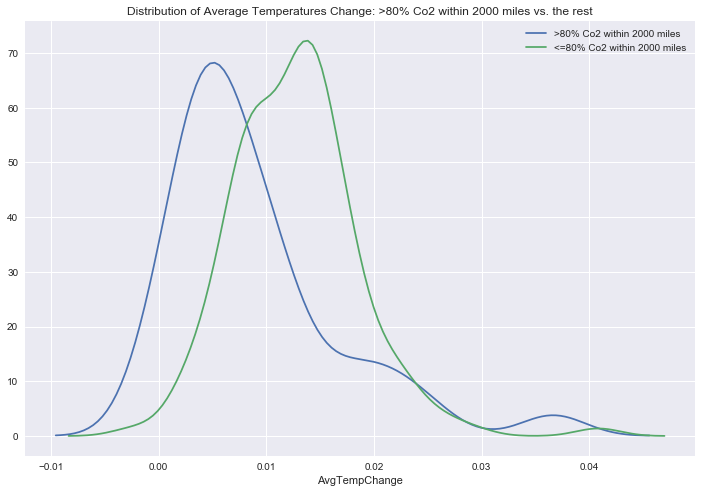

In [17]:
# compare distribution of average temperatures change between countries >80% Co2 within 2000 miles and the rest
plt.figure(figsize=(12,8))
plt.title('Distribution of Average Temperatures Change: >80% Co2 within 2000 miles vs. the rest')
sns.distplot(TempChange80plus, hist=False, label='>80% Co2 within 2000 miles')
sns.distplot(TempChange80less, hist=False, label='<=80% Co2 within 2000 miles');

The chart above illustrates that the distributions of average temperature change are different between the countries with >80% Co2 within 2000 miles against the rest. I found it interesting that, contrary to my first intuition, the countries with >80% Co2 within 2000 miles have less changes in temperature. Let's take a look at the distributions from a different angle.

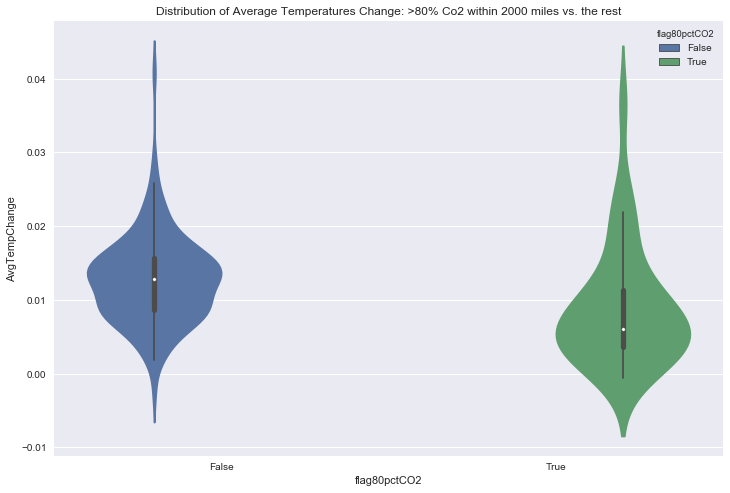

In [13]:
# compare distribution of temperatures in 1990 and 2010
plt.figure(figsize=(12,8))
plt.title('Distribution of Average Temperatures Change: >80% Co2 within 2000 miles vs. the rest')
sns.violinplot(x='flag80pctCO2', y='AvgTempChange', hue='flag80pctCO2', data=df_change);

The violin plot above also tells us the same story. Now, let's perform Z-test to validate our insights from visualization.

#### Modeling: Z-test

In [14]:
ttest_ind(TempChange80plus, TempChange80less)

Ttest_indResult(statistic=-3.2513339419030447, pvalue=0.001380763683512286)

#### Results
* The observed p-value is less than 0.025 and we reject null hypothesis that there is no difference in average temperatures change for the period of 1960 - 2012 between countries with >80% Co2 within 2000 miles and the rest.
* However, test statistic of -3.25 suggests that, contorary to our alternative hypothesis, countries with >80% Co2 within 2000 miles experienced less average temperatures changes than the rest.

### Approach 3: Comparing Slope of Fitted Line
The results from Z-test are somewhat counter-intuitive as one of the prevailing view of global warming is in its causal relation to high-level of CO2 emissions. This contradicting views can stem from the definition of "temperature change". In the previous section, average temperatures change is defined as the difference between first (1960) and last year (2012) in the dataset, divided by number of years. In this section, as an alternative definition, temperature change is now defined as the slope of a fitted line in each country's decomposed trend temperature data obtained from [this analysis](https://github.com/masamurai/AppliedDataScience/blob/master/project/notebooks/100-temperature-change.ipynb).

#### Data clensing

In [25]:
# load data
df_master_result_sm = pd.read_csv('../data/df_master_result_sm.csv')

# get the list of countries >80% Co2 within 2000 miles extracted in notebook 09-hypothesis-test2
country_80pctCO2 = list(pd.read_csv('../data/list_80pctCO2.csv', header=None)[0])

# flag countries >80% Co2 within 2000 miles using the list obove
df_master_result_sm['flag80pctCO2'] = np.where(df_master_result_sm['country'].isin(country_80pctCO2), True, False)

# split the dataset based on whether or not countries >80% Co2 within 2000 miles
df_80pctCO2plus = df_master_result_sm[df_master_result_sm['flag80pctCO2'] == True].reset_index()
df_80pctCO2less = df_master_result_sm[df_master_result_sm['flag80pctCO2'] == False].reset_index()

#### Visualization

In [47]:
def plot_fitted_trend(df, title):
    '''
    plot linear lines fitted to decomposed temperature trend data
    '''
    list_country = df['country'].unique()

#     plt.figure(figsize=(12,8))
    plt.title(title)
    plt.xlim(1960, 2020)
    for i in list_country:
        df_reg = df[df['country'] == i]
        sns.regplot(x='Year', y='trend', ci=None, scatter=False, color='grey', data=df_reg)
    sns.regplot(x='Year', y='trend', ci=None, scatter=False, color='red', data=df)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['Year'], df['trend']);
    print('slope: ' + str(slope))
    print('p-value: ' + str(p_value))

slope: 0.021396302368047827
p-value: 0.39446560668732455


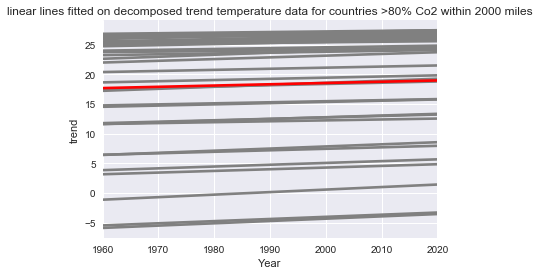

In [49]:
plot_fitted_trend(df_80pctCO2plus, 'linear lines fitted on decomposed trend temperature data for countries >80% Co2 within 2000 miles')

Each grey line in the chart above represents a linear line regressed on decomposed temperature trend data for each country, and the overlayed red line summarizes the temperature changes for countries >80% Co2 within 2000 miles. Let's plot the same data for the rest of the countries.

slope: 0.023388303356095274
p-value: 0.03776895335846459


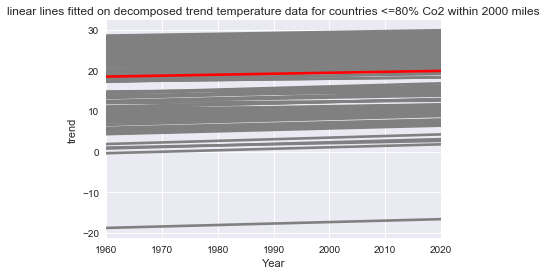

In [50]:
plot_fitted_trend(df_80pctCO2less, 'linear lines fitted on decomposed trend temperature data for countries <=80% Co2 within 2000 miles')

This chart is equivalent of the previous chart for the rest of the countries. Now, let's compare the summary lines for the two group of the countries.

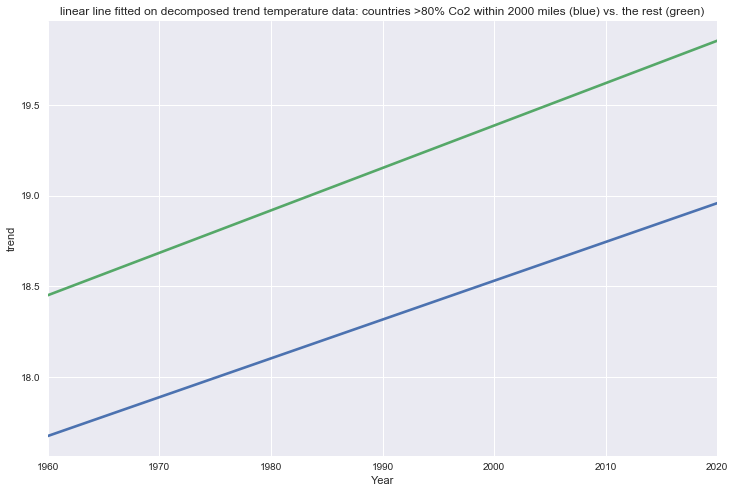

In [59]:
plt.figure(figsize=(12,8))
plt.title('linear line fitted on decomposed trend temperature data: countries >80% Co2 within 2000 miles (blue) vs. the rest (green)')
plt.xlim(1960, 2020)
sns.regplot(x='Year', y='trend', ci=None, scatter=False, data=df_80pctCO2plus)
sns.regplot(x='Year', y='trend', ci=None, scatter=False, data=df_80pctCO2less);

The chart above compares a fitted linear line that summarizes temperature changes for countries >80% Co2 within 2000 miles and the rest. While the intercepts are different, it appears that the slopes are very similar and the two lines run paralell. Now, let's confirm the insights with Z-test by comparing mean slope of the two groups of countries.

#### Method: Z-test

In [77]:
# load data
df_fit = pd.read_csv('../data/df_fit.csv')

# add a flag
df_fit['flag80pctCO2'] = np.where(df_fit['country'].isin(country_80pctCO2), True, False)

# get p-values for the two groups of the countries
pval_80plus = df_fit[df_fit['flag80pctCO2']]['slope']
pval_80less = df_fit[~df_fit['flag80pctCO2']]['slope']

# perform Z-test
ttest_ind(pval_80plus, pval_80less)

Ttest_indResult(statistic=-1.278163628571919, pvalue=0.20290398316512437)

#### Results

P-value of 0.20 indicates that the data d not provide sufficient evidence, at $\alpha = 0.5$, for us to conclude that the mean slope for countries >80% Co2 within 2000 miles is different from the rest. The same conclusion was drawn regardless of the definition of temperature changes.